This notebook is to contain notes on different models, leading up to a decision on which model to use in production.

This notebook incorporates the dataloader defined in https://github.com/axelth/us8kdata , and will also incorporate the feature extraction pipeline prototyped in notebooks/.... and implemented in hasp/{features.py, pipeline.py} etc.

imports for individual models are performed in their respective section to make it easier to see which code to transfer to the library after model selection

In [63]:
#%load_ext autoreload
#%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import classification_report, confusion_matrix

from us8kdata.loader import UrbanSound8K
from hasp.feature_pipeline import make_feature_pipeline
from hasp.feature_pipeline import make_oversampled_feature_pipeline
from hasp.augmenting_oversampler import AugmentingRandomOversampler as OverSampler
from hasp.util import combine_classes

import mlflow
from hasp.mlflow_logging import MLFlowExperiment

In [2]:
%%time
data = UrbanSound8K('../hasp/data')
train_fold = [samples for samples in data.fold_audio_generator(fold=[1, 2, 3, 6, 7, 8, 9, 10],
                                                              classID=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
val_fold = [samples for samples in data.fold_audio_generator(fold=[4],
                                                            classID=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
test_fold = [samples for samples in data.fold_audio_generator(fold=[5],
                                                             classID=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
train_y = data.filter_metadata(fold=[1, 2, 3, 6, 7, 8, 9, 10],
                              classID=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).classID
val_y = data.filter_metadata(fold=[4],
                            classID=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).classID
test_y = data.filter_metadata(fold=[5],
                             classID=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).classID

CPU times: user 432 ms, sys: 693 ms, total: 1.13 s
Wall time: 7.72 s


In [33]:
data.metadata[['classID', 'class']]

,classID,class
0,3,dog_bark
1,2,children_playing
2,2,children_playing
3,2,children_playing
4,2,children_playing
...,...,...
8727,1,car_horn
8728,1,car_horn
8729,1,car_horn
8730,1,car_horn


Test fold baseline (dummy) accuracy, precision, recall, f1
(always predicting "danger")

In [25]:
r = combine_classes([1,3,6, 8], test_y, binary=True).mean()

In [26]:
precision, recall, f1 = r, 1, (2*r) / (r+1)
r, precision, recall, f1

(0.3301282051282051, 0.3301282051282051, 1, 0.4963855421686747)

# Single sample classification
Model architectures for treating each audio file as a single example and classifying it in one go.

## Logistic Regression (baseline)

In [22]:
from sklearn.linear_model import LogisticRegression

In [24]:
target_classes = [1, 3, 8, 6]

mean_mfcc_param = {'sr':16000, 'n_mfcc': 13, 'n_fft': 256,
                    'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0, 'n_mels': 98,
                    'delta1':True, 'delta2':True}
logreg_pipeline = make_oversampled_feature_pipeline()
logreg_pipeline.set_params(
            **{'estimator': LogisticRegression(),
             'mean_mfcc__kw_args': mean_mfcc_param,
              'over_sampler': None}
        )
# ovsamp_X, ovsamp_y = logreg_pipeline[:2].fit_resample(
#     train_fold + val_fold,
#     pd.concat([train_y, val_y])
# )
logreg_pipeline[2:].fit(train_fold + val_fold,
                            combine_classes(target_classes, pd.concat([train_y, val_y]), binary=True)
                           )
logreg_pred = logreg_pipeline.predict(test_fold)
print(logreg_pipeline.score(test_fold, combine_classes(target_classes, test_y, binary=True)))
precision_recall_fscore_support(combine_classes(target_classes, test_y, binary=True),
                                logreg_pred, average='binary')

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
0.7884615384615384


(0.7322175732217573, 0.5663430420711975, 0.6386861313868614, None)

### LASSO

## KNN

## SVC

In [3]:
from sklearn.svm import SVC


In [33]:
svc_ovsamp_val_pred = svc_ovsamp_pipeline.predict(val_fold)
print(classification_report(
    combine_classes([1, 8], val_y),
    combine_classes([1, 8], svc_ovsamp_val_pred)
))
print(classification_report(
     val_y, 
    svc_ovsamp_val_pred))
labels = data.metadata[['classID', 'class']].drop_duplicates().sort_values('classID')['class'].to_list()
pd.DataFrame(confusion_matrix(val_y, svc_ovsamp_val_pred),
             index=labels,#[0,1,2,3,4,5,6,7,8, 9], 
             columns=labels)#[0,1,2,3,4,5,6,7,8, 9])

              precision    recall  f1-score   support

           1       0.51      0.46      0.48        59
           7       0.92      0.93      0.93       765
           8       0.80      0.80      0.80       166

    accuracy                           0.88       990
   macro avg       0.74      0.73      0.74       990
weighted avg       0.88      0.88      0.88       990

              precision    recall  f1-score   support

           0       0.51      0.50      0.50       100
           1       0.51      0.46      0.48        59
           2       0.55      0.41      0.47       100
           3       0.53      0.77      0.63       100
           4       0.45      0.55      0.49       100
           5       0.35      0.24      0.29       107
           6       0.77      0.53      0.62        38
           7       0.14      0.08      0.10       120
           8       0.80      0.80      0.80       166
           9       0.28      0.44      0.34       100

    accuracy           

,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
air_conditioner,50,4,6,2,11,0,0,13,10,4
car_horn,0,27,0,2,7,3,0,7,2,11
children_playing,12,0,41,13,12,0,0,4,0,18
dog_bark,1,2,8,77,2,0,5,0,4,1
drilling,3,2,4,1,55,6,0,26,0,3
engine_idling,9,0,1,4,0,26,0,6,16,45
gun_shot,0,5,1,4,2,0,20,4,0,2
jackhammer,10,6,1,2,31,32,0,10,0,28
siren,0,3,1,26,0,2,1,0,133,0
street_music,14,4,12,13,3,5,0,3,2,44


In [13]:
data.metadata[['classID', 'class']].drop_duplicates().sort_values('class')

,classID,class
22,0,air_conditioner
9,1,car_horn
1,2,children_playing
0,3,dog_bark
196,4,drilling
122,5,engine_idling
106,6,gun_shot
171,7,jackhammer
114,8,siren
94,9,street_music


### try mlflow logging

In [4]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support

<function sklearn.metrics._classification.precision_recall_fscore_support(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')>

In [9]:
%%time
# svc_experiment = MLFlowExperiment("axelth", 'svc_oversample',version="0.1")
svc_experiment = MLFlowExperiment("axelth", 'svc_oversample',version="0.3")
snippet_length = 5000
binary_train = True
target_classes = [1, 3, 8, 6]
fold_lengths = data.filter_metadata(fold=[1, 2, 3, 6, 7, 8, 9, 10]).fold.value_counts().sort_index().to_list()
n_examples = 0
res_dict = {}
mean_mfcc_grid = []
for n_mfcc in [13]:#[13, 16, 20]:#range(13, 26):
    for n_fft in [256]:#range(256, 1025, 256):
        for fmin in [0.0,]:#, 500.0]: #50.0, 100.0, 200.0, 300.0, 400.0, 500.0]:
            for fmax in [4000.0,]:# 5000.0]: #, 4000.0, 3000.0]:
                for d1 in (True,):
                    for d2 in (True,):
                        mean_mfcc_grid.append({'sr':16000, 'n_mfcc': n_mfcc, 'n_fft': n_fft,
                                           'hop_length': 128, 'fmin': fmin, 'fmax': fmax, 'n_mels': 98,
                                          'delta1':d1, 'delta2':d2})

                        
for mfcc_param in mean_mfcc_grid:
    #for oversamp in ['AddGaussianNoise', 'PitchShift', 'AirAbsorption']:
    for n_ex in fold_lengths:
    #for C in [4]:
        C = 4
        n_examples += n_ex
        svc_experiment.mlflow_create_run()

        tmp_pipeline = make_oversampled_feature_pipeline()
        tmp_pipeline.set_params(
            **{'estimator': SVC(C=C),
             'mean_mfcc__kw_args': mfcc_param,
              'over_sampler': OverSampler(augment_method='AirAbsorption', 
                                          sampling_strategy='not majority')}
        )
        for paramkey in ['estimator', 'mean_mfcc__kw_args', 'over_sampler']:
            paramval = tmp_pipeline.get_params()[paramkey]
            if type(paramval) == dict:
                svc_experiment.log_kwargs_param('mean_mfcc', paramval)
            else:
                try:
                    svc_experiment.mlflow_log_param(paramkey, float(paramval))
                except Exception:
                    svc_experiment.mlflow_log_param(paramkey, str(paramval)[:250])
                
        
        svc_experiment.mlflow_log_param('binary_train', binary_train)
        #svc_experiment.mlflow_log_param('snippet_length', snippet_length)
        svc_experiment.mlflow_log_param('n_examples', n_examples)
        
        tmp_ovsamp_X, tmp_ovsamp_y = tmp_pipeline[:2].fit_resample(
            train_fold[:n_examples], #[s for s in snippet_generator(train_fold, snippet_length=snippet_length)], 
            train_y[:n_examples])
        svc_experiment.mlflow_log_param('n_examples_ovsamp', tmp_ovsamp_X.shape[0])
        tmp_pipeline[2:].fit(tmp_ovsamp_X, #[s for s in snippet_generator(train_fold, snippet_length=snippet_length)], 
                        combine_classes(target_classes, tmp_ovsamp_y, binary=binary_train))

        
        tmp_val_pred = tmp_pipeline.predict(val_fold)
        
        if not binary_train:
            tmp_val_pred = combine_classes(target_classes, tmp_val_pred, binary=True)
        
        tmp_eval = precision_recall_fscore_support(
            tmp_val_pred,
            combine_classes(target_classes, val_y, binary=True),
            average='binary'
        )
        
        print(tmp_eval)
        res_dict[n_examples] = (tmp_eval[0], tmp_eval[1], tmp_eval[2], tmp_ovsamp_X.shape[0])
        svc_experiment.mlflow_log_metric('precision', tmp_eval[0])
        svc_experiment.mlflow_log_metric('recall', tmp_eval[1])
        svc_experiment.mlflow_log_metric('fscore', tmp_eval[2])
        svc_experiment.mlflow_log_param('target_classes', ','.join(map(str, target_classes)))
        svc_experiment.mlflow_client.set_terminated(svc_experiment.mlflow_run.info.run_id)
        

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
(0.8181818181818182, 0.6923076923076923, 0.7500000000000001, None)
Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
(0.5977961432506887, 0.6802507836990596, 0.6363636363636364, None)
Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
(0.7107438016528925, 0.7914110429447853, 0.7489114658925978, None)
Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
(0.6639118457300276, 0.7724358974358975, 0.7140740740740741, None)
Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
(0.6776859504132231, 0.8118811881188119, 0.7387387387387387, None)
Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
(0.7382920110192838, 0.8297213622291022, 0.7813411078717201, None)
Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
(0.7768595041322314, 0.8468468468468469, 0.810344827586207, None)
Use pipe.set_p

In [12]:
res_df = pd.DataFrame(res_dict).T.rename(columns={0:'precision', 1:'recall', 2:'fscore', 3:'ovsamp_n'})#.drop(columns='support')


<AxesSubplot:xlabel='audio files (inc. oversampling)'>

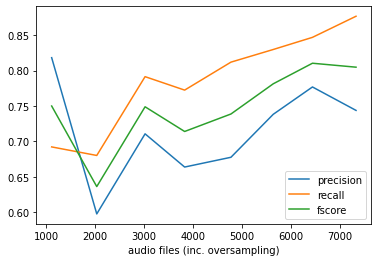

In [21]:
res_df.astype({'ovsamp_n':int}).set_index('ovsamp_n').plot(xlabel='audio files (inc. oversampling)')

In [28]:
def snippet_generator(examples, snippet_length=5000):
    for ex in examples:
        idx = max(np.random.randint(ex.shape[0]) - snippet_length, 0)
        yield ex[idx:idx+snippet_length]

In [7]:
import joblib

In [34]:
snippets = []
snippet_length = 5000
for ex in test_fold:
    idx = max(np.random.randint(ex.shape[0]) - snippet_length, 0)
    snippets.append(ex[idx:idx+snippet_length])
    

In [35]:
snippet_pred = tmp_pipeline.predict(snippets)

In [37]:
tmp_pipeline.score(snippets, combine_classes([1,3,8], test_y, binary=True))

0.7959401709401709

In [36]:
precision_recall_fscore_support(combine_classes([1,3,8], test_y, binary=True),
                                snippet_pred, average='binary')

(0.6989795918367347, 0.5092936802973977, 0.589247311827957, None)

In [15]:
four_class_pred = tmp_pipeline.predict(test_fold)

In [16]:
tmp_pipeline.score(test_fold, combine_classes([1,3,6, 8], test_y, binary=True))

0.8600427350427351

In [17]:
precision_recall_fscore_support(combine_classes([1,3,6, 8], test_y, binary=True),
                                four_class_pred, average='binary')

(0.8272058823529411, 0.7281553398058253, 0.774526678141136, None)

In [15]:
data.filter_metadata(fold=[1, 2, 3, 6, 7, 8, 9, 10]).fold.value_counts().sort_index()

1     873
2     888
3     925
6     823
7     838
8     806
9     816
10    837
Name: fold, dtype: int64

### final SVC model with fixed oversampling

In [6]:
%%time
target_classes = [1, 3, 8, 6]

mean_mfcc_param = {'sr':16000, 'n_mfcc': 13, 'n_fft': 256,
                    'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0, 'n_mels': 98,
                    'delta1':True, 'delta2':True}
C=4
fix_ovsamp_pipeline = make_oversampled_feature_pipeline()
fix_ovsamp_pipeline.set_params(
            **{'estimator': SVC(C=C),
             'mean_mfcc__kw_args': mean_mfcc_param,
              'over_sampler': OverSampler(augment_method='AirAbsorption', sampling_strategy='not majority')}
        )
ovsamp_X, ovsamp_y = fix_ovsamp_pipeline[:2].fit_resample(
    train_fold + val_fold,
    pd.concat([train_y, val_y])
)
fix_ovsamp_pipeline[2:].fit(ovsamp_X,
                            combine_classes(target_classes, ovsamp_y, binary=True)
                           )
fix_ovsamp_pred = fix_ovsamp_pipeline.predict(test_fold)


Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline
CPU times: user 6min 9s, sys: 1min 38s, total: 7min 48s
Wall time: 2min 14s


In [7]:
print(fix_ovsamp_pipeline.score(test_fold, combine_classes(target_classes, test_y, binary=True)))
precision_recall_fscore_support(combine_classes(target_classes, test_y, binary=True),
                                fix_ovsamp_pred, average='binary')

0.8611111111111112


(0.8185053380782918, 0.7443365695792881, 0.7796610169491527, None)

In [19]:
import joblib
# prediction part of pipeline
joblib.dump(fix_ovsamp_pipeline[2:], 'final_pipeline-20220831.joblib')

['final_pipeline-20220831.joblib']

In [34]:
%%time
n_samples_after_oversampling = []
tot_len = 0
for f in fold_lengths:
    tot_len += f
    n_samples_after_oversampling.append(
        final_pipeline[:2].fit_resample(train_fold[:tot_len],
        combine_classes(target_classes, train_y[:tot_len], binary=True))[0].shape[0]
    )
n_samples_after_oversampling

CPU times: user 19.7 s, sys: 26.2 s, total: 45.9 s
Wall time: 2min 28s


[1164, 2458, 3576, 4884, 6192, 7154, 8266, 9492]

In [41]:
final_pipeline

Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x179b7c5e0>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(augment_method='AirAbsorption',
                                             sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x13db10a60>,
                                     kw_args={'delta1': True, 'delta2': True,
                                              'fmax': 4000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mels': 98, 'n_mfcc': 13,
                                              'sr': 16000})),
                ('scaler', StandardScaler()), ('estimator', SVC(C=4))])

In [ ]:
for fnumber in [1, 2, 3, 6, 7, 8, 9, 10]:
    
    print(data.filter_metadata(fold=[fnumber]).classID.value_counts().min())

## RandomForest

## XGBoost

In [66]:
from xgboost import XGBClassifier
#model_xgb = XGBClassifier()
#model_xgb.fit(train_pre, train_y)

In [19]:
xgb_val_prediction = model_xgb.predict(val_pre)
print(classification_report(
    combine_classes([1, 8], val_y),
    combine_classes([1, 8], xgb_val_prediction)
))
print(classification_report(
     val_y, 
    xgb_val_prediction))
pd.DataFrame(confusion_matrix(val_y, xgb_val_prediction),
             index=[0,1,2,3,4,5,6,7,8,9], 
             columns=[0,1,2,3,4,5,6,7,8,9])

              precision    recall  f1-score   support

           1       0.67      0.37      0.48        59
           7       0.92      0.94      0.93       765
           8       0.80      0.83      0.81       166

    accuracy                           0.89       990
   macro avg       0.80      0.71      0.74       990
weighted avg       0.88      0.89      0.88       990

              precision    recall  f1-score   support

           0       0.20      0.08      0.11       100
           1       0.67      0.37      0.48        59
           2       0.42      0.41      0.41       100
           3       0.46      0.75      0.57       100
           4       0.47      0.55      0.50       100
           5       0.35      0.26      0.30       107
           6       0.47      0.66      0.55        38
           7       0.28      0.10      0.15       120
           8       0.80      0.83      0.81       166
           9       0.26      0.49      0.34       100

    accuracy           

,0,1,2,3,4,5,6,7,8,9
0,8,3,22,7,15,9,0,2,8,26
1,2,22,2,7,5,1,0,8,1,11
2,9,1,41,14,10,0,5,1,2,17
3,1,0,5,75,6,0,6,0,4,3
4,1,5,2,4,55,4,0,15,1,13
5,4,1,2,6,0,28,17,0,14,35
6,0,0,4,5,0,0,25,4,0,0
7,9,0,2,0,27,33,0,12,0,37
8,0,0,4,24,0,0,0,0,137,1
9,6,1,14,21,0,4,0,1,4,49


### XGBoost with oversampled features


In [35]:
oversampled_pipe = make_oversampled_feature_pipeline()
oversampled_pipe

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x28019cee0>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler', None),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x148b6d820>,
                                     kw_args={'fmax': None, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 512,
                                              'n_mels': 100, 'n_mfcc': 20,
                                              'sr': 16000})),
                ('scaler', StandardScaler()), ('estimator', None)])

In [7]:
oversampled_pipe.get_params()

{'memory': None,
 'steps': [('pad',
   FunctionTransformer(func=<function np_pad_wrapper at 0x280178d30>,
                       kw_args={'max_len': 64000})),
  ('over_sampler', None),
  ('mean_mfcc',
   FunctionTransformer(func=<function samples_to_mean_mfcc at 0x105ebc670>,
                       kw_args={'fmax': None, 'fmin': 0.0, 'hop_length': 128,
                                'n_fft': 512, 'n_mels': 100, 'n_mfcc': 20,
                                'sr': 16000})),
  ('scaler', StandardScaler()),
  ('estimator', None)],
 'verbose': False,
 'pad': FunctionTransformer(func=<function np_pad_wrapper at 0x280178d30>,
                     kw_args={'max_len': 64000}),
 'over_sampler': None,
 'mean_mfcc': FunctionTransformer(func=<function samples_to_mean_mfcc at 0x105ebc670>,
                     kw_args={'fmax': None, 'fmin': 0.0, 'hop_length': 128,
                              'n_fft': 512, 'n_mels': 100, 'n_mfcc': 20,
                              'sr': 16000}),
 'scaler': Standar

In [38]:
oversampled_pipe.set_params(estimator=XGBClassifier(n_estimators=400, 
                              learning_rate=0.025, 
                              max_depth=8, 
                              objective='multi:softmax',
                              nthread=4),                          
                           mean_mfcc__kw_args={'fmin':0, 'fmax':3000, 'n_mels': 98},
                           over_sampler=OverSampler())

Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x28019cee0>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x148b6d820>,
                                     kw_args={'fmax': 3000, 'fmin': 0,
                                              'n_mels': 98})),
                ('scaler', StandardScaler()),
                ('esti...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.025, max_bin=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=400,
                               n_jobs=None, nthread=4, num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, ...))])

In [39]:
%%time
oversampled_pipe.fit(train_fold, train_y);

CPU times: user 8min 48s, sys: 55.9 s, total: 9min 44s
Wall time: 2min 12s


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x28019cee0>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x148b6d820>,
                                     kw_args={'fmax': 3000, 'fmin': 0,
                                              'n_mels': 98})),
                ('scaler', StandardScaler()),
                ('esti...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.025, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=8, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=400, n_jobs=4, nthread=4,
                               num_parallel_tree=1, objective='multi:softmax',
                               predictor='auto', random_state=0, ...))])

In [42]:
xgb_ovsamp_val_pred = oversampled_pipe.predict(val_fold)
print(classification_report(
    combine_classes([0,2,4,5,6,7,9], val_y),#[1,3, 8]
    combine_classes([0,2,4,5,6,7,9], xgb_ovsamp_val_pred)#
))
print(classification_report(
     val_y, 
    xgb_ovsamp_val_pred))
labels = data.metadata[['classID', 'class']].drop_duplicates().sort_values('classID')['class'].to_list()
pd.DataFrame(confusion_matrix(val_y, xgb_ovsamp_val_pred, ),
             index=labels,#[0,1,2,3,4,5,6,7,8, 9], 
             columns=labels)#[0,1,2,3,4,5,6,7,8, 9])

              precision    recall  f1-score   support

           0       0.56      0.48      0.52       100
           2       0.47      0.47      0.47       100
           4       0.42      0.56      0.48       100
           5       0.32      0.27      0.29       107
           6       0.92      0.63      0.75        38
           7       0.21      0.08      0.12       120
           8       0.80      0.83      0.82       325
           9       0.31      0.54      0.40       100

    accuracy                           0.54       990
   macro avg       0.50      0.48      0.48       990
weighted avg       0.54      0.54      0.53       990

              precision    recall  f1-score   support

           0       0.56      0.48      0.52       100
           1       0.64      0.39      0.48        59
           2       0.47      0.47      0.47       100
           3       0.57      0.75      0.65       100
           4       0.42      0.56      0.48       100
           5       0.32 

,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
air_conditioner,48,1,11,0,15,10,0,0,1,14
car_horn,1,23,0,8,5,2,0,7,2,11
children_playing,7,0,47,8,22,0,0,4,0,12
dog_bark,2,4,5,75,7,0,1,0,4,2
drilling,4,0,0,5,56,5,0,21,0,9
engine_idling,12,0,16,2,0,29,0,0,16,32
gun_shot,0,1,2,5,0,0,24,4,0,2
jackhammer,8,6,0,0,26,37,1,10,0,32
siren,0,0,4,13,2,3,0,0,140,4
street_music,4,1,15,15,1,4,0,1,5,54


#### oversampled gridsearch

In [85]:
mean_mfcc_grid = []
for n_mfcc in [13, 16, 20]:#range(13, 26):
    for n_fft in range(256, 1025, 256):
        for fmin in [0.0, 300.0, 500.0]: #50.0, 100.0, 200.0, 300.0, 400.0, 500.0]:
            for fmax in [None, 3000.0, 4000.0, 5000.0]: #, 4000.0, 3000.0]:
                mean_mfcc_grid.append({'sr':16000, 'n_mfcc': n_mfcc, 'n_fft': n_fft,
                                       'hop_length': 128, 'fmin': fmin, 'fmax': fmax})
len(mean_mfcc_grid)

144

In [86]:
xgb_grid = [
    XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=8, objective='multi:softmax'),
    XGBClassifier(n_estimators=400, learning_rate=0.025, max_depth=8, objective='multi:softmax')
]

In [87]:
from sklearn.model_selection import GridSearchCV

In [91]:
%%time
gs = GridSearchCV(oversampled_pipe, 
                  dict(mean_mfcc__kw_args=mean_mfcc_grid,
                      estimator=xgb_grid), 
                  cv=2, verbose=2, n_jobs=1)
gs_res = gs.fit(train_fold, train_y)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  51.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  50.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  53.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  56.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  58.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  55.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  57.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  57.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  59.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.3min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.6min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.5min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.6min
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 512, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.4min
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 512, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.3min
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 768, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  53.9s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 768, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  52.8s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  59.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  58.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  59.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  59.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  36.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  35.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  36.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  34.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  37.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  35.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  37.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  36.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  38.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  35.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  36.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  35.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  36.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  36.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  36.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  37.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  37.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  36.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  39.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  36.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  38.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  36.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  37.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  37.2s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 512, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  45.4s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 512, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  43.6s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 768, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  52.1s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 768, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  59.6s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  59.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.0min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  41.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  41.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  41.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  41.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  42.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  39.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  41.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  41.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  50.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  41.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  41.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  39.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  41.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  40.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  41.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  42.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  43.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  39.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  40.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  41.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  43.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  41.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  43.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  41.2s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 512, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  50.3s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 512, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  50.4s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 768, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  57.8s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 768, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  56.5s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsamp

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  40.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  39.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  40.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  40.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  40.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  40.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  40.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  41.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  40.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  39.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  40.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  40.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  41.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  39.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  42.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  41.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  43.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  41.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  42.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  43.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  41.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  39.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  41.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  39.9s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 512, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  49.7s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 512, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  49.7s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 768, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  58.1s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 768, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  57.1s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  43.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  43.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  42.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  43.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  45.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  42.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  45.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  44.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  44.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  41.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  43.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  42.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  42.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  41.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  43.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  42.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  43.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  43.9s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  43.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  42.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  45.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  43.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  43.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  41.3s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 512, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  51.3s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 512, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  52.8s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 768, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  58.9s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 768, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.0min
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.4min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.1min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 16, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  48.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time=  45.6s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  46.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time=  46.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  47.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time=  47.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  49.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time=  46.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  46.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  44.8s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  49.2s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time=  48.0s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  50.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time=  47.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  49.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time=  46.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  47.1s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time=  47.3s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  47.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  47.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  47.4s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time=  45.7s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  47.5s


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 256, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time=  46.7s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 512, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time=  59.1s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 512, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time=  56.2s
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 768, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.1min
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsampl

[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 768, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.1min
[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.3min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 0.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 300.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': None}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 3000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 4000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.2min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=800
  return f(*args, **kwargs)
/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None,
              random_state=None, reg_alpha=None, ...), mean_mfcc__kw_args={'sr': 16000, 'n_mfcc': 20, 'n_fft': 1024, 'hop_length': 128, 'fmin': 500.0, 'fmax': 5000.0}; total time= 1.3min


/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


CPU times: user 2d 7h 28min 45s, sys: 13h 3min 21s, total: 2d 20h 32min 7s
Wall time: 9h 9min 21s


In [93]:
gs_res.best_params_

{'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=400, n_jobs=None,
               num_parallel_tree=None, objective='multi:softmax', predictor=None,
               random_state=None, reg_alpha=None, ...),
 'mean_mfcc__kw_args': {'sr': 16000,
  'n_mfcc': 16,
  'n_fft': 256,
  'hop_length': 128,
  'fmin': 0.0,
  'fmax': 3000.0}}

In [94]:
xgb_gs_val_pred = gs.best_estimator_.predict(val_fold)
print(classification_report(
    combine_classes([1, 8], val_y),
    combine_classes([1, 8], xgb_gs_val_pred)
))
print(classification_report(
     val_y, 
    xgb_gs_val_pred))
pd.DataFrame(confusion_matrix(val_y, xgb_gs_val_pred),
             index=[0,1,2,3,4,5,6,7,8,9], 
             columns=[0,1,2,3,4,5,6,7,8,9])

/Users/axel/.pyenv/versions/3.8.12/envs/us8kdata/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           1       0.39      0.53      0.45        59
           7       0.92      0.91      0.91       765
           8       0.84      0.79      0.81       166

    accuracy                           0.86       990
   macro avg       0.72      0.74      0.72       990
weighted avg       0.87      0.86      0.87       990

              precision    recall  f1-score   support

           0       0.47      0.20      0.28       100
           1       0.39      0.53      0.45        59
           2       0.40      0.49      0.44       100
           3       0.50      0.77      0.60       100
           4       0.63      0.54      0.58       100
           5       0.37      0.24      0.29       107
           6       0.75      0.63      0.69        38
           7       0.24      0.07      0.11       120
           8       0.84      0.79      0.81       166
           9       0.24      0.49      0.32       100

    accuracy           

,0,1,2,3,4,5,6,7,8,9
0,20,10,32,0,13,4,0,0,0,21
1,2,31,1,5,8,1,0,3,1,7
2,4,0,49,17,3,3,5,1,0,18
3,0,0,7,77,2,0,3,0,6,5
4,2,7,1,5,54,1,0,20,0,10
5,6,1,9,2,0,26,0,0,12,51
6,0,0,5,4,0,0,24,3,0,2
7,4,24,4,0,5,30,0,9,0,44
8,0,0,5,30,0,0,0,0,131,0
9,5,6,11,15,1,6,0,1,6,49


In [19]:
%%time
post_search_pipeline = make_oversampled_feature_pipeline()
post_search_pipeline.set_params(
**{'estimator': XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {'sr': 16000,'n_mfcc': 16,
  'n_fft': 256,'hop_length': 128,
  'fmin': 0.0, 'fmax': 3000.0, 'n_mels': 98},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')}
)
post_search_pipeline.fit(train_fold, train_y)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


KeyboardInterrupt: 

In [17]:
xgb_ps_val_pred = post_search_pipeline.predict(val_fold)
print(classification_report(
    combine_classes([1, 8], val_y),
    combine_classes([1, 8], xgb_ps_val_pred)
))
print(classification_report(
     val_y, 
    xgb_ps_val_pred))
pd.DataFrame(confusion_matrix(val_y, xgb_ps_val_pred),
             index=[0,1,2,3,4,5,6,7,8,9], 
             columns=[0,1,2,3,4,5,6,7,8,9])

              precision    recall  f1-score   support

           1       0.36      0.44      0.40        59
           7       0.91      0.89      0.90       765
           8       0.78      0.79      0.78       166

    accuracy                           0.85       990
   macro avg       0.68      0.71      0.69       990
weighted avg       0.86      0.85      0.85       990

              precision    recall  f1-score   support

           0       0.19      0.08      0.11       100
           1       0.36      0.44      0.40        59
           2       0.49      0.43      0.46       100
           3       0.43      0.77      0.55       100
           4       0.61      0.56      0.58       100
           5       0.42      0.25      0.31       107
           6       0.55      0.61      0.57        38
           7       0.24      0.08      0.12       120
           8       0.78      0.79      0.78       166
           9       0.23      0.45      0.30       100

    accuracy           

,0,1,2,3,4,5,6,7,8,9
0,8,16,6,7,4,5,0,0,23,31
1,3,26,0,9,8,1,0,5,1,6
2,5,0,43,19,8,1,5,2,0,17
3,2,1,7,77,2,0,2,0,5,4
4,2,7,3,1,56,3,0,19,0,9
5,6,0,5,14,0,27,11,0,5,39
6,0,0,6,4,0,0,23,4,0,1
7,11,14,2,0,13,24,0,10,0,46
8,0,0,3,31,0,0,0,0,131,1
9,5,8,12,18,1,4,1,2,4,45


## VGGish

# Sequence of samples classification
Model architectures for treating each file as a sequence of sample frames, making the classification either based on a subset or on the frame as a whole.

## HMM

## RNN